# Global (Imports, Constants, Utils etc) 



## GPU type

In [35]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Jun 11 14:53:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 32%   40C    P3    31W / 170W |    462MiB / 12045MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Module & Goggle Drive import

In [36]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  !pip install keras_tuner
except:
  pass

In [37]:
import os
import sys
import tensorflow as tf
import tensorflow.keras as keras
import keras_tuner as kt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from typing import List, Dict, Tuple
from scipy.signal import savgol_filter
from tqdm.notebook import trange, tqdm
from pickle import (
    dump,
    load
)

from tensorflow.keras import (
    layers,
    Model,
    Sequential,
    optimizers
)
from tensorflow.keras.preprocessing.sequence import (
    pad_sequences    
)

from pprint import pprint
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer



## Constant definision

In [38]:
# If runs on google colab or not
try:
  import google.colab
  BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/drone_research"
except:
  BASE_DIR = "/home/israzex/Desktop/drone_homecoming_rl/artificial_gps"

DATA_FOLDER_NAME = "data"
DATA_FOLDER_PATH = os.path.join(BASE_DIR, DATA_FOLDER_NAME)
MODELS_FOLDER_NAME = "models"
MODELS_FOLDER_PATH = os.path.join(BASE_DIR, MODELS_FOLDER_NAME)
TUNERS_FOLDER_NAME = "tuners"
TUNERS_FOLDER_PATH = os.path.join(BASE_DIR, TUNERS_FOLDER_NAME)



ORIENTATION_SENSORS = ["orientation_x", "orientation_y", "orientation_z", "orientation_w"]
ORIENTATION_DIFF_COLUMNS = [f"{field}_diff" for field in ORIENTATION_SENSORS]

LINEAR_ACCELERATION_SENSORS = ["linear_acceleration_x", "linear_acceleration_y", "linear_acceleration_z",]
ANGULAR_ACCELERATION_SENSORS = [ "angular_acceleration_x", "angular_acceleration_y", "angular_acceleration_z"]
ANGULAR_VELOCITY_SENSORS = [ "angular_velocity_x", "angular_velocity_y", "angular_velocity_z"]
BAROMETER_SENSORS = ["barometer_altitude", "barometer_pressure"]
TIMESTAMP_COLUMN = "motor_state_timestamp"

INPUT_1_CLOUMNS = [*ORIENTATION_SENSORS, 
                   *ORIENTATION_DIFF_COLUMNS,
                   *LINEAR_ACCELERATION_SENSORS,
                   *ANGULAR_ACCELERATION_SENSORS]
INPUT_2_CLOUMNS = [TIMESTAMP_COLUMN]
INPUT_3_CLOUMNS = [*BAROMETER_SENSORS]

INPUT_CLOUMNS = [*ORIENTATION_SENSORS, 
                 *LINEAR_ACCELERATION_SENSORS,
                 *ANGULAR_ACCELERATION_SENSORS,
                 TIMESTAMP_COLUMN,
                 *BAROMETER_SENSORS
]

OUTPUT_COLUMNS = ["position_x", "position_y", "position_z"]
# OUTPUT_COLUMNS = [ "position_z"]
# OUTPUT_COLUMNS = ["gps_latitude", "gps_longitude"]
# OUTPUT_COLUMNS = ["gps_altitude", "gps_latitude", "gps_longitude"]

In [39]:
def get_recordings_files():
    all_csv_files = os.listdir(DATA_FOLDER_PATH)

    all_csv_files.remove("bot-train-3_23Apr_17:24_record.csv")
    return all_csv_files


In [40]:
def columns_names_to_indexes(columns: List[str], target_columns_list: list):
  indexes = []
  for index, column in enumerate(target_columns_list):
    if column in columns:
      indexes.append(index)

  return indexes

In [41]:
# Set float 64
tf.keras.backend.set_floatx('float32')

In [42]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

## Utils


### Save and Load models

In [43]:
def save_model_with_scalers_binary(model, scaler_x, scaler_y, model_name: str):
    """
    Saves models with the x, y scaler objects to a binary library using pickle library
    """
    model_file_name = f"{model_name}_model.pkl"
    model_file_path = os.path.join(MODELS_FOLDER_PATH, model_file_name)
    scaler_x_file_name = f"{model_name}_scaler_x.pkl"
    scaler_x_file_path = os.path.join(MODELS_FOLDER_PATH, scaler_x_file_name)
    scaler_y_file_name = f"{model_name}_scaler_y.pkl"
    scaler_y_file_path = os.path.join(MODELS_FOLDER_PATH, scaler_y_file_name)

    with open(model_file_path, "wb") as file:
        dump(model, file)

    with open(scaler_x_file_path, "wb") as file:
        dump(scaler_x, file)

    with open(scaler_y_file_path, "wb") as file:
        dump(scaler_y, file)
        
def load_model_with_scalers_binary(model_name: str):
    """
    Saves models with the x, y scaler objects to a binary library using pickle library
    """
    model_file_name = f"{model_name}_model.pkl"
    model_file_path = os.path.join(MODELS_FOLDER_PATH, model_file_name)
    scaler_x_file_name = f"{model_name}_scaler_x.pkl"
    scaler_x_file_path = os.path.join(MODELS_FOLDER_PATH, scaler_x_file_name)
    scaler_y_file_name = f"{model_name}_scaler_y.pkl"
    scaler_y_file_path = os.path.join(MODELS_FOLDER_PATH, scaler_y_file_name)

    with open(model_file_path, "rb") as file:
        model = load(file)

    with open(scaler_x_file_path, "rb") as file:
        scaler_x = load(file)

    with open(scaler_y_file_path, "rb") as file:
        scaler_y = load(file)

    return model, scaler_x, scaler_y

## Data Split

In [44]:
def split_data(data: np.array, train_per = 0.95, dev_per= 0.5):
    """
    Splits data into train, dev and test
    :return:
    """
    data_len = len(data)

    train, dev, test = np.split(data, [int(train_per * data_len),
                                       int((dev_per + train_per) * data_len)])

    return train, dev, test


## Shuffle dataset

In [45]:
def shuffle_data_set(x_data: np.array, y_data: np.array):
    example_amount = x_data.shape[0]
    shuffle_indexes = np.random.permutation(example_amount)
    
    x_data = x_data[shuffle_indexes]
    y_data = y_data[shuffle_indexes]

    return x_data, y_data

# Data Preprocessing

### Load from single file

In [12]:
def load_flight_steps_from_file(csv_name: str, input_columns: list, output_columns: list):
    """

    @param csv_name:
    @param input_columns:
    @param output_columns:
    @return:
    """
    if not csv_name.endswith("csv"):
        raise ValueError(f"File with unsupported extension, expected csv (file: {csv_name})")

    csv_path = os.path.join(DATA_FOLDER_PATH, csv_name)
    flight_df = pd.read_csv(csv_path)
    x_df = flight_df[input_columns].copy()

    # Barometer data smoothing
    x_df[BAROMETER_SENSORS] = x_df[BAROMETER_SENSORS].ewm(span=20, adjust=False).mean() 

    # Creating orientation diff
    next_orientaion_df = x_df[ORIENTATION_SENSORS].shift(-1)
    orientaion_diff = (next_orientaion_df - x_df[ORIENTATION_SENSORS])
    orientaion_diff.rename(columns={key : f"{key}_diff" for key in orientaion_diff.columns}, inplace=True)

    # Creating timestamp diff
    timestamp_columns = [TIMESTAMP_COLUMN]
    next_time_df = x_df[timestamp_columns].shift(-1)
    time_diff_df = (next_time_df - x_df[timestamp_columns]) / 1_000_000_000
    x_df.loc[:, timestamp_columns] = time_diff_df

    # Appanding orientation diff
    x_df = pd.concat([x_df, orientaion_diff], axis=1)

    y_df = flight_df[output_columns].copy()

    # Creating X, Y position diff
    columns = ["position_x", "position_y"]
    next_position_df = y_df[columns].shift(-1)
    position_diff = y_df[columns] - next_position_df
    y_df.loc[:, columns] = position_diff

    # Drops the last record because the process is based of difference
    x_df.drop(x_df.tail(1).index, inplace=True)
    y_df.drop(y_df.tail(1).index, inplace=True)

    return x_df, y_df

In [13]:
def load_dataset(input_columns: list, output_columns: list):
    """
    Loads flight steps and orders it to sequences of sequence_length length.
    In order to feed it to rnn/lstm s2s model

    @param input_columns: The input columns
    @param output_columns: The outputs columns
    @return:
    """
    all_csv_files = get_recordings_files()

    # x, y data from all flight sessions
    x_sessions = []
    y_sessions = []

    for csv_name in all_csv_files:
        try:
            x_df, y_df = load_flight_steps_from_file(csv_name, input_columns, output_columns)

            x_sessions.append(x_df)
            y_sessions.append(y_df)

        except ValueError as error:
            print(str(error))

    x_df = pd.concat(x_sessions, ignore_index=True)
    y_df = pd.concat(y_sessions, ignore_index=True)

    return x_df, y_df


In [14]:
# load_flight_steps_from_file("bot-train-1_23Apr_18:02_record.csv", INPUT_COLUMNS, OUTPUT_COLUMNS)

### Preprocess data

In [15]:
def preprocess_ann_dataset(x_df: pd.DataFrame, y_df : pd.DataFrame):
    # scaler_x = ColumnTransformer([
    #     # ("rotor_sensors", StandardScaler(), ["rotor_a_speed", "rotor_b_speed",
    #                                       # "rotor_c_speed", "rotor_d_speed"]),
    #     ("accelerator_values", MinMaxScaler((-1,1)), ACCELOMETER_SENSORS),
    #     ("orientation", MinMaxScaler((-1,1)), ORIENTATION_SENSORS),
    #     ("orientation_diff", MinMaxScaler((-1,1)), [f"{field}_diff" for field in ORIENTATION_SENSORS]),
    #     ("barometer", MinMaxScaler(), BAROMETER_SENSORS),
    #     # ("magnetometer_x_y", MinMaxScaler((-1,1)),["magnetometer_magnetic_field_body_x", 
    #     #                                   "magnetometer_magnetic_field_body_y"]),
    #     # ("magnetometer_z", MinMaxScaler(),["magnetometer_magnetic_field_body_z"]),                      
    #     # ("rotors_other", MinMaxScaler(),["rotor_a_thrust", "rotor_a_torque_scaler",
    #     #                                   "rotor_b_thrust", "rotor_b_torque_scaler",
    #     #                                   "rotor_c_thrust", "rotor_c_torque_scaler",
    #     #                                   "rotor_d_thrust", "rotor_d_torque_scaler",]),
    #     ],
    #     remainder='passthrough')
    scaler_y = MinMaxScaler()
    scaler_x = MinMaxScaler((-1,1))
    data_x = scaler_x.fit_transform(x_df)

    data_y = y_df.to_numpy()
    data_y = scaler_y.fit_transform(data_y)

    data_x = data_x.astype(np.float32)
    data_y = data_y.astype(np.float32)
    return data_x, data_y, scaler_x, scaler_y

In [16]:
def load_preprocessed_dataset():
    """
    Loads the whole dataset with preprocessing

    @param input_columns: Input columns names
    @param output_columns: Output columns names
    @param sequence_length: The size of input x sequence
    @return: Loaded, preprocessed, shuffled, splitted data set
    """
    x_data, y_data = load_dataset(INPUT_CLOUMNS, OUTPUT_COLUMNS)

    x_data, y_data, scaler_x, scaler_y = preprocess_ann_dataset(x_data, y_data)

    INPUT_CLOUMNS_TEMP = INPUT_CLOUMNS[:]
    INPUT_CLOUMNS_TEMP.extend(ORIENTATION_DIFF_COLUMNS)

    pred_speed_input_indexes = columns_names_to_indexes(INPUT_1_CLOUMNS, INPUT_CLOUMNS_TEMP)
    pred_x_y_pos_input_indexes = columns_names_to_indexes(INPUT_2_CLOUMNS, INPUT_CLOUMNS_TEMP)
    pred_z_pos_input_indexes = columns_names_to_indexes(INPUT_3_CLOUMNS, INPUT_CLOUMNS_TEMP)

    train_x_1, dev_x_1, test_x_1 = split_data(x_data[:,pred_speed_input_indexes], train_per=0.88, dev_per=0.12)
    train_x_2, dev_x_2, test_x_2 = split_data(x_data[:,pred_x_y_pos_input_indexes], train_per=0.88, dev_per=0.12)
    train_x_3, dev_x_3, test_x_3 = split_data(x_data[:,pred_z_pos_input_indexes], train_per=0.88, dev_per=0.12)
    
    train_x = (train_x_1, train_x_2, train_x_3)
    dev_x = (dev_x_1, dev_x_2, dev_x_3)

    train_y, dev_y, test_y = split_data(y_data, train_per=0.88, dev_per=0.12)

    return train_x, train_y, dev_x, dev_y, scaler_x, scaler_y

# Feature Analysis

In [ ]:
x_df, y_df = load_flight_steps_from_file("bot-train-1_23Apr_17_39_record.csv",INPUT_COLUMNS, OUTPUT_COLUMNS)

NameError: ignored

In [ ]:
x_df.describe()

NameError: ignored

In [ ]:
x_df.sample(10)

In [ ]:
### Feature Analysis

x_df, y_df = load_dataset(INPUT_COLUMNS, OUTPUT_COLUMNS)

#### Initial feature analysis

print(x_df.head())
print(y_df.head())

#### X Value Analysis

print(x_df[MAGNOMETER_SENSORS].describe())

print(x_df[BAROMETER_SENSORS].describe())

print(x_df[ROTOR_SENSORS].describe())

print(x_df.describe())

#### Target Value analysis

print(y_df.describe())

bins = 100

print(y_df.shape)

output = plt.hist(y_df["linear_velocity_x"], bins=bins)
plt.title('linear_velocity_x');
plt.show()

output = plt.hist(y_df["linear_velocity_y"], bins=bins)
plt.title('linear_velocity_y');
plt.show()

output = plt.hist(y_df["linear_velocity_z"], bins=bins)
plt.title('linear_velocity_z');
plt.show()

# There are many outliers, most of the data is distributed ebove zero
# Removes outliers
valid_indexes = (np.abs(stats.zscore(y_df)) < 10).all(axis=1)
x_df = x_df[valid_indexes]
y_df = y_df[valid_indexes]

bins = 100

print(y_df.shape)

output = plt.hist(y_df["linear_velocity_x"], bins=bins)
plt.title('linear_velocity_x');
plt.show()

output = plt.hist(y_df["linear_velocity_y"], bins=bins)
plt.title('linear_velocity_y');
plt.show()

output = plt.hist(y_df["linear_velocity_z"], bins=bins)
plt.title('linear_velocity_z');
plt.show()

# print(x_df.dtypes)
# print()
# print(y_df.dtypes)

# plt.figure(figsize=(20,15))
# sns.heatmap(x_df.corr(),annot=True);

#Model creation and training 

In [55]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [56]:
train_x, train_y, dev_x, dev_y, scaler_x, scaler_y = load_preprocessed_dataset()

In [57]:
def create_ann_model() -> Model:
    """
    Creates LSTM model
    @return:
    """
    pred_speed_input = layers.Input(shape=len(INPUT_1_CLOUMNS))
    pred_speed_hidden = layers.Dense(200, activation="relu")(pred_speed_input)
    pred_speed_hidden = layers.Dense(300, activation="relu")(pred_speed_hidden)
    pred_speed_hidden = layers.Dense(200, activation="relu")(pred_speed_hidden)
    pred_speed_ouput = layers.Dense(2, activation="linear")(pred_speed_hidden)

    pred_x_y_pos_input = layers.Input(shape=len(INPUT_2_CLOUMNS))
    pred_x_y_pos_hideen =  layers.Dense(16, activation="relu")(pred_x_y_pos_input)

    combined =  layers.Concatenate()([pred_speed_ouput, pred_x_y_pos_hideen])

    hidden = layers.Dense(16, activation="sigmoid")(combined)
    pos_x_y_out = layers.Dense(2, activation="linear")(hidden)

    b2z_pos_input = layers.Input(shape=len(INPUT_3_CLOUMNS))
    b2z_pos_hidden =  layers.Dense(16, activation="tanh")(b2z_pos_input)
    z_pos_out =  layers.Dense(1)(b2z_pos_hidden)

    combined_out =  layers.Concatenate()([pos_x_y_out, z_pos_out])

    # model = tf.keras.Model(inputs=[model_1_input, b2z_pos_output], outputs=[output_layer], name="position_predict")
    model = tf.keras.Model(inputs=[pred_speed_input, pred_x_y_pos_input, b2z_pos_input],
                           outputs=combined_out, name="position_predict")
    # model = tf.keras.Model(inputs=b2z_pos_input,
    #                        outputs=z_pos_out, name="position_predict")
    model.compile(loss='mean_squared_error',
                  optimizer="adam")

    return model
    

def create_ann_tuned_model(input_columns_amount: int, output_columns_amount: int) -> Model:
    """
    Creates LSTM model
    @return:
    """
    input_layer = layers.Input(shape=(None, input_columns_amount))
    layer = layers.Dense(512, return_sequences=True, dropout=0.4)(input_layer)
    layer = layers.LSTM(16, return_sequences=True)(layer)
    layer = layers.Dense(16)(layer)
    output_layer = layers.Dense(output_columns_amount)(layer)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mean_squared_error',
                  optimizer=optimizers.Adam(learning_rate=0.005))

    return model

In [ ]:
model = create_ann_model()
history = model.fit(train_x,
          train_y,
          epochs=300,
          batch_size=512,
          validation_data=(dev_x, dev_y))

Epoch 1/300
1216/1216 [==============================] - 3s 2ms/step - loss: 0.0336 - val_loss: 0.0092
Epoch 2/300
1216/1216 [==============================] - 2s 2ms/step - loss: 0.0072 - val_loss: 0.0059
Epoch 3/300
1216/1216 [==============================] - 2s 2ms/step - loss: 0.0047 - val_loss: 0.0041
Epoch 4/300
1216/1216 [==============================] - 2s 2ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 5/300
1216/1216 [==============================] - 2s 2ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 6/300
1216/1216 [==============================] - 2s 2ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 7/300
1216/1216 [==============================] - 2s 2ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 8/300
1216/1216 [==============================] - 2s 2ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 9/300
1216/1216 [==============================] - 2s 2ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 10/300
1216/1216 [==============================] - 2s 2ms/step - l

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.plot(loss)
plt.plot(val_loss)

## Save model

In [ ]:
model_name = "ann_pos_11Jun_1510"
save_model_with_scalers_binary(model, scaler_x, scaler_y, model_name)

# Model tasting

In [52]:
def plot_model_prediction(real_xy_pos, pred_xy_pos):
    # real_xy_pos = np.round(real_xy_pos, decimals=3)
    # real_xy_pos = np.round(real_xy_pos, decimals=3)
    real_xy_pos_without_zeros = real_xy_pos.copy()
    real_xy_pos_without_zeros[real_xy_pos_without_zeros == 0] = 1
    approximation_error = (100 * (np.absolute(pred_xy_pos - real_xy_pos) / np.absolute(real_xy_pos_without_zeros)).mean(axis=0))[0]
    print(f"approximation_error: {approximation_error}")
    
    plt.figure(figsize =(10, 5))
    plt.plot(pred_xy_pos[:, 0].reshape(-1, 1))
    plt.plot(real_xy_pos[:, 0].reshape(-1, 1))

    plt.show()

    plt.figure(figsize =(10, 5))
    plt.plot(pred_xy_pos[:, 1].reshape(-1, 1))
    plt.plot(real_xy_pos[:, 1].reshape(-1, 1))

    plt.show()

    plt.figure(figsize =(10, 5))
    plt.plot(pred_xy_pos[:, 2].reshape(-1, 1))
    plt.plot(real_xy_pos[:, 2].reshape(-1, 1))

    plt.show()

In [53]:
def test_model_prediction(model: tf.keras.Model,
                          scaler_x: MinMaxScaler,
                          scaler_y: MinMaxScaler, 
                          record_file_name: str) -> None:
  recording_path = os.path.join(DATA_FOLDER_PATH, record_file_name)
  x_df, real_xy_pos_step = load_flight_steps_from_file(recording_path, INPUT_CLOUMNS, OUTPUT_COLUMNS)
  real_xy_pos_step = real_xy_pos_step.to_numpy()

  print(real_xy_pos_step)
  data_x = scaler_x.transform(x_df)

  INPUT_CLOUMNS_TEMP = INPUT_CLOUMNS[:]
  INPUT_CLOUMNS_TEMP.extend(ORIENTATION_DIFF_COLUMNS)

  pred_speed_input_indexes = columns_names_to_indexes(INPUT_1_CLOUMNS, INPUT_CLOUMNS_TEMP)
  pred_x_y_pos_input_indexes = columns_names_to_indexes(INPUT_2_CLOUMNS, INPUT_CLOUMNS_TEMP)
  pred_z_pos_input_indexes = columns_names_to_indexes(INPUT_3_CLOUMNS, INPUT_CLOUMNS_TEMP)

  data_x_1 = data_x[:,pred_speed_input_indexes]
  data_x_2 = data_x[:,pred_x_y_pos_input_indexes]
  data_x_3 = data_x[:,pred_z_pos_input_indexes]

  pred_y = model.predict([data_x_1, data_x_2, data_x_3])
  # pred_y = model.predict(data_x_3)
  pred_xy_pos_step = scaler_y.inverse_transform(pred_y)

  real_xy_pos = np.add.accumulate(real_xy_pos_step[:, [0,1]])
  pred_xy_pos = np.add.accumulate(pred_xy_pos_step[:, [0,1]])

  print(real_xy_pos.shape)
  print( real_xy_pos_step[:, 2].shape)

  real_xy_pos = np.hstack([real_xy_pos, real_xy_pos_step[:, 2].reshape(-1,1)])
  pred_xy_pos = np.hstack([pred_xy_pos, pred_xy_pos_step[:, 2].reshape(-1,1)])
  plot_model_prediction(real_xy_pos, pred_xy_pos)

[[ 2.28881836e-05  1.25885010e-04 -1.05499100e+02]
 [ 1.52587891e-05  9.53674316e-05 -1.05498825e+02]
 [-1.14440918e-05  4.38690186e-05 -1.05498611e+02]
 ...
 [ 0.00000000e+00  0.00000000e+00 -1.07643211e+02]
 [ 0.00000000e+00  0.00000000e+00 -1.07643173e+02]
 [ 0.00000000e+00  0.00000000e+00 -1.07643127e+02]]
(5001, 2)
(5001,)
approximation_error: 32.60213943353505


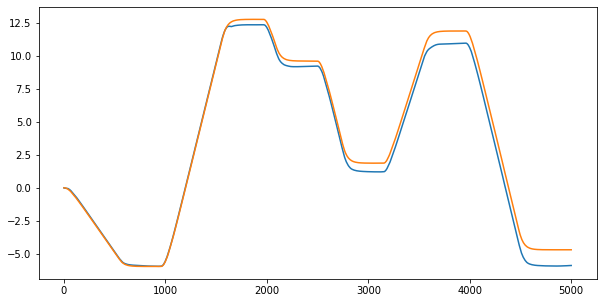

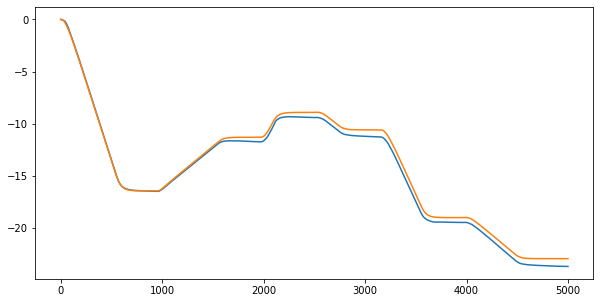

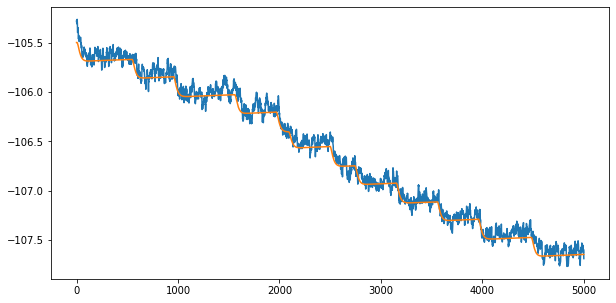

In [54]:
# record_file_name = "bot-expert-3_22Apr_21:31_record.csv"
record_file_name = "bot-train-3_23Apr_17:24_record.csv"

model_name = "ann_pos_11Jun_1448"
model, scaler_x, scaler_y = load_model_with_scalers_binary(model_name)
test_model_prediction(model, scaler_x, scaler_y, record_file_name)   

# Hyperparameters tuning

### Model Creation

In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [ ]:
def create_dynamic_model(hp: kt.HyperParameters) -> Model:
    """
    Creates Sequence model dynamically
    :param hp: Hyper parameters (Initialized by a tuning algorithm)
    :return:
    """
    model = Sequential()
    model.add(layers.Input(shape=(hp.get("input_columns_amount"))))    
    activation = hp.Choice("dense_actiavtion", ["tanh", "relu", "sigmoid"])
    dense_layers = hp.Int("dense_layers", min_value=1, max_value=4)

    for layer_id in range(dense_layers):
      layer_units = hp.Int(f"dense_{layer_id}_units", min_value=16, max_value=256, step=16)

      model.add(layers.Dense(layer_units,
                             activation=activation,
                             kernel_regularizer=keras.regularizers.L2(
                                 hp.Choice(f"l2_regulator_{layer_id}", [0.0, 0.1, 0.01, 0.001]))))

      dropout_rate = hp.Float(f"dense_{layer_id}_dropout_rate", min_value=0, max_value=0.4, step=0.05)
      model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(hp.get("output_columns_amount")))

    learning_rate = hp.Choice("adam_learning_rate", [0.01, 0.001, 0.002, 0.005])

    if hp.Boolean(f"learning_rate_decay"):
        learning_rate = optimizers.schedules.ExponentialDecay(
            initial_learning_rate=learning_rate,
            decay_steps=10000,
            decay_rate=0.9)

    model.compile(loss='mean_squared_error',
                  optimizer=optimizers.Adam(learning_rate=learning_rate))

    return model



### The Tuner



In [ ]:
hp = kt.HyperParameters()
hp.Fixed("input_columns_amount", len(INPUT_SEQUENCE_COLUMNS))
hp.Fixed("output_columns_amount", len(OUTPUT_SEQUENCE_COLUMNS))

project_name = "ann_12MarNight_position_with_regularizator"
tuner = kt.BayesianOptimization(
    create_dynamic_model,
    hyperparameters=hp,
    objective="val_loss",
    max_trials=1000,
    directory=TUNERS_FOLDER_PATH,
    project_name=project_name,
    executions_per_trial = 1
)

In [ ]:
# tuner.get_best_hyperparameters()[0].values

In [ ]:
model = tuner.get_best_models()[0]
model_name = "position_best_11Mar_1"
save_model_with_scalers_binary(model, scaler_x, scaler_y, model_name)

### Truning

In [ ]:
tensorboard_dir = os.path.join(os.path.join(TUNERS_FOLDER_PATH,project_name), "tensorboard")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_dir, 
                                                      histogram_freq=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, baseline=0.00001)
tuner.search(train_x,
            train_y,
             validation_data=(dev_x, dev_y),
             epochs = 2000,
             batch_size=512,
             callbacks=[early_stop, tensorboard_callback])



# Position Test


In [ ]:
import math
from vincenty import vincenty

In [ ]:
>>> boston = (42.3541165, -71.0693514)
>>> newyork = (40.7791472, -73.9680804)
>>> vincenty(boston, newyork)

In [ ]:
df = pd.read_csv(os.path.join(DATA_FOLDER_PATH,"bot-train-1_23Apr_19:23_record.csv"))

In [ ]:
points =  list(zip(df["gps_latitude"], df["gps_longitude"]))[::3000]
points_pos = list(zip(df["position_x"], df["position_y"]))[::3000]

In [ ]:
for index in range(len(points) - 1):
  vincenty_distance = vincenty(points[index], points[index + 1]) * 1000

  x1, y1 = points_pos[index]
  x2, y2 = points_pos[index + 1]
  calculated_distance = math.sqrt(math.pow(x2 - x1, 2) + math.pow(y2 - y1, 2))

  print(f"{vincenty_distance} - {calculated_distance}")